# Setup

In [2]:
%pip install ipywidgets
%pip install postgres
%pip install matplotlib
%pip install seaborn
%matplotlib inline


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [3]:
import os
import struct

from plot.color import Color
from plot.formatter import LabelFormatter, NumberFormatter, Scale, Grid, LambdaFormatter, Decorator, PercentFormatter
from plot.frame import latexify, cm2inch, Format, GridFrame, SingleFrame
from plot.boxplot import BoxPlot
from plot.barplot import BarPlot
from plot.lineplot import LinePlot
from plot.linestyle import Linestyle
from plot.location import Location
from plot.marker import Marker

# Freq Token Compression

In [4]:
# read text8_tokens.csv
text8_tokens = []
with open('text8_tokens.csv', 'r') as f:
    text8_tokens = f.read().splitlines()
text8_tokens = [int(token.strip()) for token in text8_tokens if token.strip()]
print(len(text8_tokens), "tokens found")

distinct_tokens = set(text8_tokens)
print(len(distinct_tokens), "distinct tokens found")
distinct_tokens = list(sorted(distinct_tokens))

print(distinct_tokens[0], distinct_tokens[-1])
distinct_tokens_map = {token: i for i, token in enumerate(distinct_tokens)}
compressed_tokens = [distinct_tokens_map[token] for token in text8_tokens]

with open('text8_tokens_compressed.csv', 'w') as f:
    for token in compressed_tokens:
        f.write(f"{token}\n")

# write the text8_tokens as 16bit integers (binary, 2 bytes per integer)
with open('text8_tokens_16bit.bin', 'wb') as f:
    for token in compressed_tokens:
        assert 0 <= token < 65536, "Token out of range for 16-bit unsigned short"
        f.write(struct.pack('<H', token))  # Little-endian unsigned short (2 bytes)

19428084 tokens found
35844 distinct tokens found
64 143855


In [5]:
# Compute histogram for token counts [0, 9), [10, 99), [100, 999), [1000, 9999), [10000, 99999), [100000, 999999), [1000000, 9999999)
token_count = {}
for token in text8_tokens:
    if token in token_count:
        token_count[token] += 1
    else:
        token_count[token] = 1

histogram = [set() for _ in range(7)]
histogram_count = [0] * 7
for token, count in token_count.items():
    counter = count
    i = 0
    while counter > 9:
        counter //= 10
        i += 1
    histogram[i].add(token)
    histogram_count[i] += count


for i in range(len(histogram)):
    print(f"Histogram [{10**i}, {10**(i+1)}): {len(histogram[i])} tokens, {histogram_count[i]} counts")

Histogram [1, 10): 6504 tokens, 24899 counts
Histogram [10, 100): 14925 tokens, 642564 counts
Histogram [100, 1000): 11869 tokens, 3728956 counts
Histogram [1000, 10000): 2379 tokens, 5894861 counts
Histogram [10000, 100000): 145 tokens, 3427690 counts
Histogram [100000, 1000000): 21 tokens, 4645530 counts
Histogram [1000000, 10000000): 1 tokens, 1063584 counts


In [6]:
# Sort distinct tokens by their frequency
freq_tokens = sorted(token_count.items(), key=lambda x: x[1], reverse=True)
print("Top 10 tokens by frequency:")
for token, count in freq_tokens[:10]:
    print(f"Token: {token}, Count: {count}")

Top 10 tokens by frequency:
Token: 279, Count: 1063584
Token: 315, Count: 593767
Token: 323, Count: 420154
Token: 825, Count: 411795
Token: 304, Count: 376606
Token: 264, Count: 339329
Token: 311, Count: 318619
Token: 7168, Count: 264992
Token: 11627, Count: 250469
Token: 1378, Count: 192645


In [7]:
freq_tokens_map = {token: i for i, (token, _) in enumerate(freq_tokens)}
freq_compressed_tokens = [freq_tokens_map[token] for token in text8_tokens if token in freq_tokens_map]

for token, count in freq_tokens[:10]:
    print(f"Token: {token}, Count: {count}, Compressed: {freq_tokens_map[token]}")

with open('text8_tokens_freq_compressed.csv', 'w') as f:
    for token in freq_compressed_tokens:
        f.write(f"{token}\n")

# write the text8_tokens as 16bit integers (binary, 2 bytes per integer)
with open('text8_tokens_freq_16bit.bin', 'wb') as f:
    for token in freq_compressed_tokens:
        assert 0 <= token < 65536, "Token out of range for 16-bit unsigned short"
        f.write(struct.pack('<H', token))  # Little-endian unsigned short (2 bytes)

Token: 279, Count: 1063584, Compressed: 0
Token: 315, Count: 593767, Compressed: 1
Token: 323, Count: 420154, Compressed: 2
Token: 825, Count: 411795, Compressed: 3
Token: 304, Count: 376606, Compressed: 4
Token: 264, Count: 339329, Compressed: 5
Token: 311, Count: 318619, Compressed: 6
Token: 7168, Count: 264992, Compressed: 7
Token: 11627, Count: 250469, Compressed: 8
Token: 1378, Count: 192645, Compressed: 9


# Plots

In [12]:
uncompressed_size = 100000000  # 100 MB
storage_cost_per_byte_per_year = 12 * 20 / 1e12  # 20$ per TB/month -> 240$ per year
gpu_cost_per_hour = 0.6  # RTX 4090 on runpod
cpu_cost_per_hour = 0.1 / 14  # Hetzner 14 cores


def storage_duration(size, speed, gpu):
    uncompressed_storage_cost = storage_cost_per_byte_per_year * uncompressed_size
    compressed_storage_cost = storage_cost_per_byte_per_year * size
    compression_cost = (uncompressed_size / speed) / (60 * 60) * (gpu_cost_per_hour if gpu else cpu_cost_per_hour) if speed > 0 else 0
    # compression_cost + compressed_storage_cost * d = uncompressed_storage_cost * d
    duration = compression_cost / (uncompressed_storage_cost - compressed_storage_cost) if speed > 0 else 0  # in years
    # print(compression_cost, uncompressed_storage_cost, compressed_storage_cost, duration)
    return duration * 365

def cost_over_time(time, size, speed, gpu):
    storage_cost = storage_cost_per_byte_per_year * size * time / 365
    compression_cost = (uncompressed_size / speed) / (60 * 60) * (gpu_cost_per_hour if gpu else cpu_cost_per_hour) if speed > 0 else 0
    return compression_cost + storage_cost


def format_duration(years):
    if years >= 365:
        return f"{years / 365:.2f} years"
    return f"{years:.2f} days"

In [14]:
# Text8 (size in bytes, compression speed in bytes/sec) base size: 100.000.000 bytes
algorithms = {
    "uncompressed": (100000000, 0, False, Color.LIGHTORANGE),
    "fsst": (48111129, 100000000 / 0.204, False, Color.ORANGE),
    # 19,428,084 tokens, 35,844 distinct tokens, 151,643 tokens in tokenizer -> 2bytes per token + 1 bit per token in tokenizer
    "tokens": (19428084 * 2 + 1/8*151643, 100000000 / 46.45, False, Color.RED),
    "brotli -q 1": (35612549, 100000000 / 0.375, False, Color.BLUE),
    "zstd -1": (35054779, 100000000 / 0.257, False, Color.DARKBLUE),
    "zip": (33182194, 100000000 / 3.934, False, Color.BLUE),
    "gzip": (33182058, 100000000 / 3.969, False, Color.BLUE),
    "zstd -3": (32693862, 100000000 / 0.391, False, Color.DARKBLUE),
    "tokens + zip": (26192099 + 1/8*151643, 100000000 / (46.45 + 1.251), False, Color.RED),
    "tokens + freq + zip": (25082128 + 18/8*35844, 100000000 / (46.45 + 1.650), False, Color.RED),  # dictionary, 18 bits per used token
    "xz": (24702472, 100000000 / 12.743, False, Color.BLUE),
    "zstd -19": (24521220, 100000000 / 42.473, False, Color.DARKBLUE),
    "brotli -q 11": (24107566, 100000000 / 129.85, False, Color.BLUE),
    "zstd --ultra -22": (23250137, 100000000 / 61.87, False, Color.DARKBLUE),
    "tokens + xz": (20724776 + 1/8*151643, 100000000 / (46.45 + 9.128), False, Color.RED),
    "tokens + freq + xz": (20485784 + 18/8*35844, 100000000 / (46.45 + 9.371), False, Color.RED),  # xz instead of zip
    "paq8px -12": (16804872, 7391, False, Color.GRAY),
    "cmix": (16230986, 1043, False, Color.GRAY),
    "GPT2 (100)": (16500000, 5700, True, Color.BLACK),  # Computed on small sample not full dataset
    "QWEN 0.5B (100)": (12100000, 1450, True, Color.BLACK),  # Computed on small sample not full dataset
}

for name, (size, speed, gpu, _) in algorithms.items():
    print(f"{name:20}: {size/1000/1000:7.2f} Mbytes, {speed/1000:12.2f} Kbytes/sec, {format_duration(storage_duration(size, speed, gpu)):12} to pay off")

uncompressed        :  100.00 Mbytes,         0.00 Kbytes/sec, 0.00 days    to pay off
fsst                :   48.11 Mbytes,    490196.08 Kbytes/sec, 0.01 days    to pay off
tokens              :   38.88 Mbytes,      2152.85 Kbytes/sec, 2.29 days    to pay off
brotli -q 1         :   35.61 Mbytes,    266666.67 Kbytes/sec, 0.02 days    to pay off
zstd -1             :   35.05 Mbytes,    389105.06 Kbytes/sec, 0.01 days    to pay off
zip                 :   33.18 Mbytes,     25419.42 Kbytes/sec, 0.18 days    to pay off
gzip                :   33.18 Mbytes,     25195.26 Kbytes/sec, 0.18 days    to pay off
zstd -3             :   32.69 Mbytes,    255754.48 Kbytes/sec, 0.02 days    to pay off
tokens + zip        :   26.21 Mbytes,      2096.39 Kbytes/sec, 1.95 days    to pay off
tokens + freq + zip :   25.16 Mbytes,      2079.00 Kbytes/sec, 1.94 days    to pay off
xz                  :   24.70 Mbytes,      7847.45 Kbytes/sec, 0.51 days    to pay off
zstd -19            :   24.52 Mbytes,      

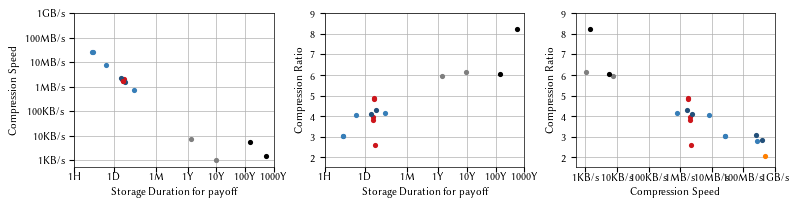

In [15]:
latexify(hyperref=False, increase_font=0)
frame = GridFrame(width=cm2inch(20), height=cm2inch(5), n_columns=3, n_rows=1)

formatter_speed = LabelFormatter(label="Compression Speed", scale=Scale.LOG,
                                 ticks=[1e3, 10e3, 100e3, 1e6, 10e6, 100e6, 1e9, 10e9, 100e9],
                                 ticklabels=['1KB/s', '10KB/s', '100KB/s', '1MB/s', '10MB/s', '100MB/s', '1GB/s', '10GB/s', '100GB/s'],
                                 grid=Grid.MAJOR, decorator=Decorator.AXISLABEL, min=1e3/2, max=1e9)
formatter_payoff = LabelFormatter(label="Storage Duration for payoff", scale=Scale.LOG,
                                  ticks=[1/24, 1, 30, 365, 3650, 36500, 365000],
                                  ticklabels=['1H', '1D', '1M', '1Y', '10Y', '100Y', '1000Y'],
                                  grid=Grid.MAJOR, decorator=Decorator.AXISLABEL, min=1/24, max=365000)
formatter_ratio = NumberFormatter(label="Compression Ratio", scale=Scale.LINEAR,
                                  ticks=[2, 3, 4, 5, 6, 7, 8, 9],
                                  grid=Grid.MAJOR, decorator=Decorator.AXISLABEL, min=1.5, max=9)

plot = LinePlot(frame[0, 0], linewidth=1.5)
plot.format_axes(xformatter=formatter_payoff, yformatter=formatter_speed)
for name, (size, speed, gpu, color) in algorithms.items():
    y = speed
    x = storage_duration(size, speed, gpu)
    plot.plot_scatter([x], [y], color=color, marker=Marker.CIRCLE, markersize=5)

plot = LinePlot(frame[0, 1], linewidth=1.5)
plot.format_axes(xformatter=formatter_payoff, yformatter=formatter_ratio)
for name, (size, speed, gpu, color) in algorithms.items():
    y = uncompressed_size / size  # Compression ratio
    x = storage_duration(size, speed, gpu)
    plot.plot_scatter([x], [y], color=color, marker=Marker.CIRCLE, markersize=5)


plot = LinePlot(frame[0, 2], linewidth=1.5)
plot.format_axes(xformatter=formatter_speed, yformatter=formatter_ratio)
for name, (size, speed, gpu, color) in algorithms.items():
    y = uncompressed_size / size  # Compression ratio
    x = speed
    plot.plot_scatter([x], [y], color=color, marker=Marker.CIRCLE, markersize=5)


frame.save(os.path.join("payoff"), format=Format.PDF)

In [78]:
import numpy as np
ticks = [1/24/60, 1/24, 1, 30, 365, 3650, 36500, 365000, 3650000]
data = {name: [] for name in algorithms.keys()}
log_spaced_days = []
for i in range(len(ticks) - 1):
    # distribute numbers logarithmic between ticks[i] and ticks[i+1]
    start = ticks[i]
    end = ticks[i+1]
    # Use 10 points per interval for demonstration
    points = np.logspace(np.log10(start), np.log10(end), num=10)
    log_spaced_days.extend(points)

# log_spaced_days now contains all the distributed values
print(log_spaced_days)
# You can now use log_spaced_days for further calculations, e.g.:
# for day in log_spaced_days:
#     for name, (size, speed, gpu, _) in algorithms.items():
#         cost = cost_over_time(day, size, speed, gpu)
#         data[name].append(cost)

[np.float64(0.0006944444444444443), np.float64(0.0010944851389925255), np.float64(0.0017249727160447029), np.float64(0.0027186580841450448), np.float64(0.004284764454382046), np.float64(0.006753039867942578), np.float64(0.010643186561021568), np.float64(0.016774285712490834), np.float64(0.026437257258531653), np.float64(0.04166666666666666), np.float64(0.04166666666666666), np.float64(0.059312408927204685), np.float64(0.08443108446595078), np.float64(0.12018746419228402), np.float64(0.1710865925783165), np.float64(0.24354139058321206), np.float64(0.34668063717531733), np.float64(0.4934991292628711), np.float64(0.7024949318414127), np.float64(1.0), np.float64(1.0), np.float64(1.4592328029610848), np.float64(2.129360373237664), np.float64(3.1072325059538586), np.float64(4.534175599114845), np.float64(6.616417768614112), np.float64(9.654893846056297), np.float64(14.088737809272455), np.float64(20.558748363608462), np.float64(29.999999999999996), np.float64(29.999999999999996), np.float64(

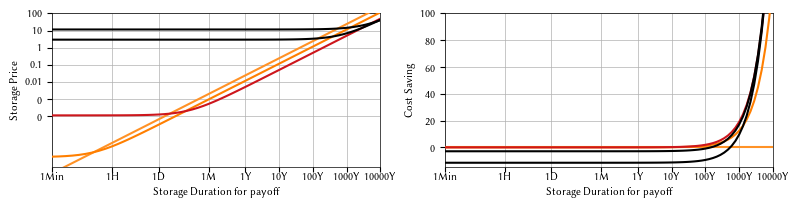

In [83]:
latexify(hyperref=False, increase_font=0)
frame = GridFrame(width=cm2inch(20), height=cm2inch(5), n_columns=2, n_rows=1)

filter = ["uncompressed", "fsst", "tokens + xz", "GPT2 (100)", "QWEN 0.5B (100)"]

formatter_time = LabelFormatter(label="Storage Duration for payoff", scale=Scale.LOG,
                                  ticks=[1/24/60, 1/24, 1, 30, 365, 3650, 36500, 365000, 3650000],
                                  ticklabels=['1Min', '1H', '1D', '1M', '1Y', '10Y', '100Y', '1000Y', '10000Y'],
                                  grid=Grid.MAJOR, decorator=Decorator.AXISLABEL, min=1/24/60, max=3650000)
formatter_price = NumberFormatter(label="Storage Price", scale=Scale.LOG,
                                  ticks=[0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                                  grid=Grid.MAJOR, decorator=Decorator.AXISLABEL, min=0.0000001, max=100)
formatter_cost = NumberFormatter(label="Cost Saving", scale=Scale.LINEAR,
                                  grid=Grid.MAJOR, decorator=Decorator.AXISLABEL, min=-15, max=100)

plot = LinePlot(frame[0, 0], linewidth=1.5, linestyle=Linestyle.SOLID)
plot.format_axes(xformatter=formatter_time, yformatter=formatter_price)
for name, (size, speed, gpu, color) in algorithms.items():
    if name not in filter:
        continue
    y = [cost_over_time(days, size, speed, gpu) for days in log_spaced_days]  # Assuming a constant price for simplicity
    x = log_spaced_days
    plot.plot(x, y, color=color)
    #plot.ax.plot(x, y, linewidth=5, linestyle="-", color=color, marker=None, markersize=None, zorder=10)
    #print(x, y)
    #plot.plot([x], [7], color=color, marker=Marker.CIRCLE, markersize=5)
    
    
plot = LinePlot(frame[0, 1], linewidth=1.5, linestyle=Linestyle.SOLID)
plot.format_axes(xformatter=formatter_time, yformatter=formatter_cost)
for name, (size, speed, gpu, color) in algorithms.items():
    if name not in filter:
        continue
    y = [cost_over_time(days, 100000000, 0, False) - cost_over_time(days, size, speed, gpu) for days in log_spaced_days]  # Assuming a constant price for simplicity
    x = log_spaced_days
    plot.plot(x, y, color=color)
    #plot.ax.plot(x, y, linewidth=5, linestyle="-", color=color, marker=None, markersize=None, zorder=10)
    #print(x, y)
    #plot.plot([x], [7], color=color, marker=Marker.CIRCLE, markersize=5)
    
frame.save(os.path.join("cost"), format=Format.PDF)

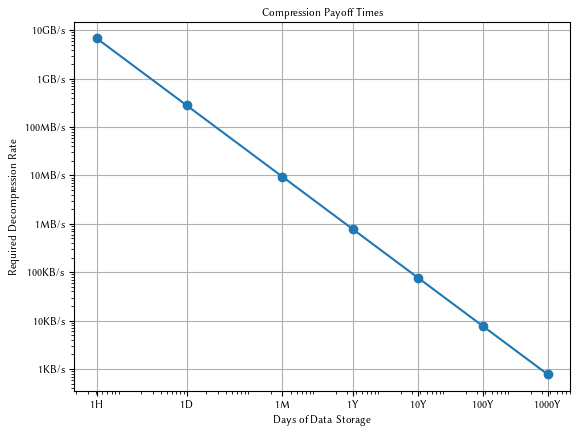

In [10]:
import matplotlib.pyplot as plt
storage_cost_per_byte_per_year = 12 * 20 / 1e12  # 20$ per TB

gpu_cost_per_hour = 0.6  # RTX 4090 on runpod
gpu_compression_ratio = 0.1

cpu_cost_per_hour = 0.1  # Hetzner 14 cores
cpu_compression_ratio = 1/1.65

day_data = []
compression_rate_data = []
for days in [1/24, 1, 30, 365, 3650, 36500, 365000]:
    storage_cost_per_byte = storage_cost_per_byte_per_year * days / 365
    compressed_storage_cost_per_byte = storage_cost_per_byte * gpu_compression_ratio
    cost_savings = storage_cost_per_byte - compressed_storage_cost_per_byte
    available_gpu_hours = cost_savings / gpu_cost_per_hour
    available_gpu_seconds = available_gpu_hours * 3600
    compression_rate = 1 / available_gpu_seconds
    day_data.append(days)
    compression_rate_data.append(compression_rate)
    # print(1 / available_gpu_seconds, "byte per second")


plt.plot(day_data, compression_rate_data, marker='o')
plt.title('Compression Payoff Times')
plt.xlabel('Days of Data Storage')
plt.ylabel('Required Decompression Rate')
plt.yscale('log')
plt.xscale('log')
plt.grid()
plt.xticks(day_data)
plt.yticks([1e3, 10e3, 100e3, 1e6, 10e6, 100e6, 1e9, 10e9], labels=['1KB/s', '10KB/s', '100KB/s', '1MB/s', '10MB/s', '100MB/s', '1GB/s', '10GB/s'])

plt.xticks([1/24, 1, 30, 365, 3650, 36500, 365000], labels=['1H', '1D', '1M', '1Y', '10Y', '100Y', '1000Y'])
plt.show()

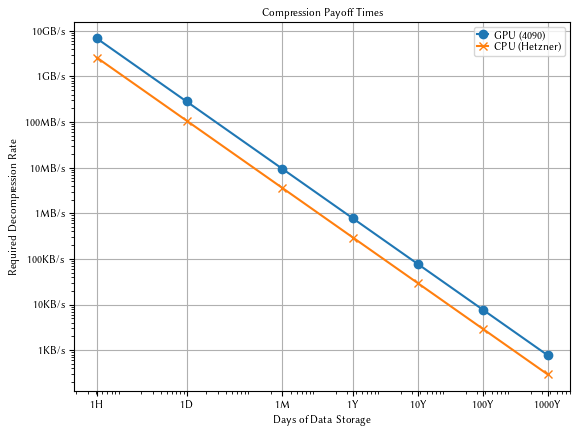

In [11]:
import matplotlib.pyplot as plt
storage_cost_per_byte_per_year = 12 * 20 / 1e12  # 20$ per TB

gpu_cost_per_hour = 0.6  # RTX 4090 on runpod
gpu_compression_ratio = 0.1

cpu_cost_per_hour = 0.1  # Hetzner 14 cores
cpu_compression_ratio = 1 / 1.65

days_list = [1/24, 1, 30, 365, 3650, 36500, 365000]
day_labels = ['1H', '1D', '1M', '1Y', '10Y', '100Y', '1000Y']


def compute_decompression_rate(cost_per_hour, compression_ratio):
    rate = []
    for days in days_list:
        storage_cost = storage_cost_per_byte_per_year * days / 365
        compressed_cost = storage_cost * compression_ratio
        savings = storage_cost - compressed_cost
        available_hours = savings / cost_per_hour
        available_seconds = available_hours * 3600
        decompression_rate = 1 / available_seconds
        rate.append(decompression_rate)
    return rate


gpu_rate = compute_decompression_rate(gpu_cost_per_hour, gpu_compression_ratio)
cpu_rate = compute_decompression_rate(cpu_cost_per_hour, cpu_compression_ratio)


plt.plot(days_list, gpu_rate, marker='o', label='GPU (4090)')
plt.plot(days_list, cpu_rate, marker='x', label='CPU (Hetzner)')

plt.title('Compression Payoff Times')
plt.xlabel('Days of Data Storage')
plt.ylabel('Required Decompression Rate')
plt.yscale('log')
plt.xscale('log')
plt.grid()

plt.xticks(days_list, labels=day_labels)
plt.yticks(
    [1e3, 10e3, 100e3, 1e6, 10e6, 100e6, 1e9, 10e9],
    labels=['1KB/s', '10KB/s', '100KB/s', '1MB/s', '10MB/s', '100MB/s', '1GB/s', '10GB/s']
)

plt.legend()
plt.show()